# Topic Modeling TDS Posts with Latent Dirichlet Analysis
## Trigrams

Based on the tutorial at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# !pip install gensim==3.8.3

In [103]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#saving models
import pickle 
import joblib

import warnings
warnings.filterwarnings("ignore")

In [104]:
#update stopwords with frequent irrelevant words identified during EDA
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [105]:
filename = '../data/cleaned_no_outliers.csv'

In [106]:
#read in the data
df = pd.read_csv(filename)

In [107]:
#remove non-text, non-Y columns
df = df.drop(columns=['date', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 
       'number_paragraphs'])

#### Combine Title & Subtitle

In [108]:
df['combined_title'] = (df['title'] + ' ' + df['subtitle'])

In [109]:
df = df.drop(columns = ['title', 'subtitle']).reset_index(drop=True)

#### Remove Punctuation & Make Lowercase

In [110]:
text_cols = ['section_titles', 'paragraphs', 'combined_title']

In [111]:
for col in text_cols:
    df[col] = df[col].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

#### Remove the 'Min Read' Phrase at the Beginning of Each Paragraph

In [112]:
#remove all text up to and including 'min read' in the beginning of the paragraphs
df['paragraphs'] = df['paragraphs'].map(lambda x: (x[x.index('min read')+9:] if (x.count('min read') > 0) else x))
                     

#### Remove the Brackets Surrounding The Section Titles

In [113]:
#remove brackets surrounding the section titles
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("[",""))
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("]",""))

#### Combine Text Columns

In [114]:
df['text'] = df['combined_title'] + df['section_titles'] + df['paragraphs']

In [115]:
df = df.drop(columns = ['section_titles', 'paragraphs', 'combined_title'])

In [116]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [19]:
data_words_nostops = remove_stopwords(data_words)

#### Initialize Spacy 'en' Model

In [20]:
#!spacy download en_core_web_lg

In [21]:
nlp = spacy.load('en_core_web_lg')

In [22]:
# remove exception from rule-based exceptions - not a fan of "datum" showing up in my corpus along with data....
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]

#### Lemmatize

In [23]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Form Bigrams & Trigrams

In [24]:
data_words_bigrams = make_bigrams(data_lemmatized)

In [25]:
data_words_trigrams = make_trigrams(data_lemmatized)

### Trigram Modeling

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Create Corpus
texts = data_words_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### Build LDA Mallet Model

In [27]:
#start with 10 topics & fit model
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#### Evaluate with Coherence Score & Visualization

In [28]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#display coherence score
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.47621407144178274


INTERPRET

In [29]:
#  https://stackoverflow.com/questions/54684552/issue-with-topic-word-distributions-after-malletmodel2ldamodel-in-gensim
def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [30]:
converted_model = ldaMalletConvertToldaGen(ldamallet)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/LDAmallet_trigrams_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.045918  0.033022       1        1   8.055388
1      0.180381  0.011523       2        1   9.144112
2      0.199598 -0.225536       3        1   9.624387
3     -0.145275 -0.007345       4        1  10.081511
4     -0.160304 -0.031814       5        1  10.543291
5      0.151180  0.115638       6        1  12.775902
6     -0.039604  0.041529       7        1   8.482723
7     -0.010570 -0.231872       8        1   9.559497
8     -0.223169  0.024059       9        1  11.186734
9      0.093681  0.270796      10        1  10.546455, topic_info=          Term           Freq          Total Category  logprob  loglift
80        data  126984.000000  126984.000000  Default  30.0000  30.0000
241      model   66197.000000   66197.000000  Default  29.0000  29.0000
932   function   29460.000000   29460.000000  Default  28.0000  28.0000
939      image   19433.000000   19433.000000  Default  27.0000  27.0000
322    science   17410.000000   17410.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
210      level    1590.232279    6214.502442  Topic10  -5.8569   0.8864
891       case    1878.850933   15576.514477  Topic10  -5.6901   0.1343
1052    change    1696.625004   11718.422532  Topic10  -5.7922   0.3169
165       high    1556.277083    9930.013059  Topic10  -5.8785   0.3961
27        base    1529.112977   11677.006047  Topic10  -5.8961   0.2164

[962 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
424       1  0.975318      abcd
6855      6  1.000655  academia
1124      5  0.610596  accuracy
1124      9  0.389389  accuracy
2307      1  0.560855    action
...     ...       ...       ...
421       6  0.332298      year
421       7  0.411312      year
421      10  0.256506      year
1817      4  0.876606     ymean
1343      9  1.057352    youden

[1876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

#### Compute Optimal Number of Topics Based on Coherence

In [31]:
# an adapted version of a function to compute coherence values over a range of total topic numbers
# https://github.com/RaRe-Technologies/gensim/issues/2500

def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary,
                                         random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)
        joblib.dump(model,f'stored_models/ldamallet_model{num_topics}_tri.pkl')
        joblib.dump(id2word,f'stored_models/id2word_dictionary_mallet{num_topics}_tri.pkl')

    return model_list, coherence_values, num_topics_list

In [32]:
# calculate coherence values over the specific range of numbers of topics

model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=id2word,all_corpus=corpus,
                                                                         texts=data_words_trigrams,start=4,limit=30, step=2)

#store the results in a dataframe
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

#find the number of topics that corresponds to the maximum coherence value
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

#save this as as the optimal model
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_num_topics, id2word=id2word, random_seed=42)

In [33]:
#save optimal models
joblib.dump(id2word, f'stored_models/id2word_dictionary_mallet_tri.pkl')
joblib.dump(optimal_model,f'stored_models/optimal_ldamallet_model_tri.pkl')

['stored_models/optimal_ldamallet_model_tri.pkl']

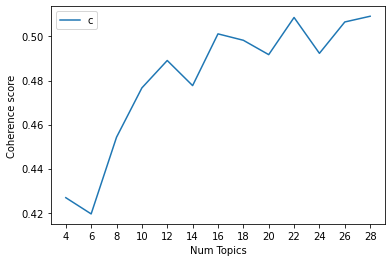

In [34]:
# Show coherence values graph
limit=30; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(ticks=range(4,30,2))
plt.legend(("coherence_values"), loc='best')
plt.show()

The coherence peaks at 22 topics

### Create & Visualize Model with Optimal Number of Topics

#### LDA Mallet Model: 22 Topics

In [225]:
optimal_model = joblib.load('stored_models/ldamallet_model22_tri.pkl')

In [226]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5086019611815986


In [227]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model22_tri.html') 
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.069571  0.231812       1        1  5.463395
1     -0.105238 -0.171506       2        1  6.618428
2      0.102172 -0.188148       3        1  3.712407
3      0.019252  0.081920       4        1  3.795327
4     -0.274089  0.112434       5        1  5.014166
5     -0.096075 -0.253796       6        1  5.617344
6      0.109787 -0.079228       7        1  3.550044
7      0.074670  0.152570       8        1  4.586798
8     -0.260813  0.040706       9        1  4.681352
9      0.013892  0.074830      10        1  4.227083
10     0.007835  0.085923      11        1  6.146433
11     0.177209  0.136994      12        1  4.473434
12    -0.125875  0.087718      13        1  3.870278
13    -0.086349 -0.006785      14        1  3.816097
14     0.206796  0.014698      15        1  4.287931
15    -0.031736 -0.088450      16        1  6.188523
16     0.017112 -0.206420      17        1  4.989002
17     0.088829 -0.098236      18        1  3.066579
18     0.114956 -0.014361      19        1  4.109047
19     0.188640  0.085396      20        1  3.757141
20     0.057720  0.036128      21        1  3.866240
21    -0.129121 -0.034197      22        1  4.162951, topic_info=         Term           Freq          Total Category  logprob  loglift
241     model   65260.000000   65260.000000  Default  30.0000  30.0000
80       data  126449.000000  126449.000000  Default  29.0000  29.0000
939     image   19676.000000   19676.000000  Default  28.0000  28.0000
932  function   29139.000000   29139.000000  Default  27.0000  27.0000
572   feature   21295.000000   21295.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
331       set    1320.168091   19635.877424  Topic22  -5.1135   0.4793
529   dataset    1325.863412   22009.939558  Topic22  -5.1092   0.3695
420     write    1010.344321    9006.596963  Topic22  -5.3809   0.9913
760    result     973.894550   18288.998235  Topic22  -5.4177   0.2462
142    follow     957.947711   19864.323563  Topic22  -5.4342   0.1471

[2119 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
6119      21  0.863868   abovegiven
17076     14  0.996524  accelerator
17958     18  1.002162       accent
1553       1  0.141965       access
1553       3  0.056169       access
...      ...       ...          ...
12915      4  0.999875         yolo
17562      4  0.997616        yolov
1343      15  1.039761       youden
19085      1  0.987368         yyyy
2915      12  0.877602           ³⁰

[5246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

### Find the Dominant Topic in Each Document

In [228]:
pd.set_option('max_colwidth', 100)

In [229]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_trigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [230]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_trigrams)
df_dominant_topic=pd.DataFrame()
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to pmid numbers
df_dominant_topic.index = df.index


In [231]:
# show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5375,"data, science, learn, scientist, project, job, work, machine, skill, learning","[ultimate_guide, ace, code, interview, data, scientist, data, science, ultimate_guide, ace, code..."
1,1,17.0,0.3722,"game, player, team, play, movie, goal, item, top, number, match","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,7.0,0.4125,"layer, input, output, network, neural_network, deep, function, loss, training, learn","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision_transformer_vit,..."
3,3,6.0,0.2477,"time, series, data, day, price, month, year, date, change, forecast","[stock_price, analysis, panda, altair, practical, guide, panda, altairstock, price, analysis, pa..."
4,4,14.0,0.4691,"test, sample, metric, result, error, case, group, number, positive, high","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


#### Find the most representative document for each topic

In [232]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to pmid numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [233]:
# Show topics and keywords
doc_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
8693,0.0,0.8647,"function, python, list, column, method, panda, code, object, dataframe, return","[useful, thing, know, python, extremely, useful, function, expression, know, python, useful, thi..."
1077,1.0,0.7260,"data, science, learn, scientist, project, job, work, machine, skill, learning","[top, path, become, data, scientist, top, path, become, data, scientist, table, content, introdu..."
320,2.0,0.7516,"data, country, number, year, location, city, state, area, covid, analysis","[dengue, case, town_council, singapore, dengue, case, july, december, dengue, case, town_council..."
61,3.0,0.6390,"image, dataset, object, video, pixel, label, detection, detect, face, result","[raw, image, processing, python, preprocesse, raw, image, machine, learn, pipelinesraw, image, p..."
1218,4.0,0.7780,"code, python, file, run, package, project, create, library, command, version","[publish, python, package, pypi, publish, python, packageshow, publish, python, package, pypi, p..."
1703,5.0,0.6812,"data, business, company, product, customer, team, analytic, process, user, tool","[set, slas, data, pipeline, opinionwhy, set, slas, data, pipeline, sla, slas, matter, data, reli..."
5649,6.0,0.6047,"time, series, data, day, price, month, year, date, change, forecast","[imply, volatility, assess, option, risk, correctly, calculate, visualize, implied_volatility, i..."
5942,7.0,0.7098,"layer, input, output, network, neural_network, deep, function, loss, training, learn","[create, vgg, scratch, tensorflow, implement, vgg, scratch, create, vgg, scratch, tensorflow, en..."
3532,8.0,0.7299,"create, api, app, application, run, cloud, service, deploy, build, web","[build, small, service, deploy, kubernete, integrate, api_gateway, building, small, service, dep..."
4938,9.0,0.6542,"word, text, language, sentence, document, topic, nlp, sentiment, task, tweet","[text, vectorization, term, frequency_inverse_document, frequency, tfidf, technique, convert, te..."


#### Explore Relationship Between Dominant Topic and Number of Citations

In [234]:
df.head()

,claps,text
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...


In [235]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5375,"data, science, learn, scientist, project, job, work, machine, skill, learning","[ultimate_guide, ace, code, interview, data, scientist, data, science, ultimate_guide, ace, code..."
1,1,17.0,0.3722,"game, player, team, play, movie, goal, item, top, number, match","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,7.0,0.4125,"layer, input, output, network, neural_network, deep, function, loss, training, learn","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision_transformer_vit,..."
3,3,6.0,0.2477,"time, series, data, day, price, month, year, date, change, forecast","[stock_price, analysis, panda, altair, practical, guide, panda, altairstock, price, analysis, pa..."
4,4,14.0,0.4691,"test, sample, metric, result, error, case, group, number, positive, high","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


In [236]:
#merge on index
combined_df = pd.DataFrame()
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [237]:
combined_df.columns

Index(['claps', 'text', 'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib',
       'Keywords', 'Text'],
      dtype='object')

In [238]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [239]:
combined_df.head()

,claps,text,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,1.0,0.5375,"data, science, learn, scientist, project, job, work, machine, skill, learning"
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,17.0,0.3722,"game, player, team, play, movie, goal, item, top, number, match"
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,7.0,0.4125,"layer, input, output, network, neural_network, deep, function, loss, training, learn"
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,6.0,0.2477,"time, series, data, day, price, month, year, date, change, forecast"
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,14.0,0.4691,"test, sample, metric, result, error, case, group, number, positive, high"


In [240]:
#the topics are not ordinal, so I will convert them to strings

combined_df['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


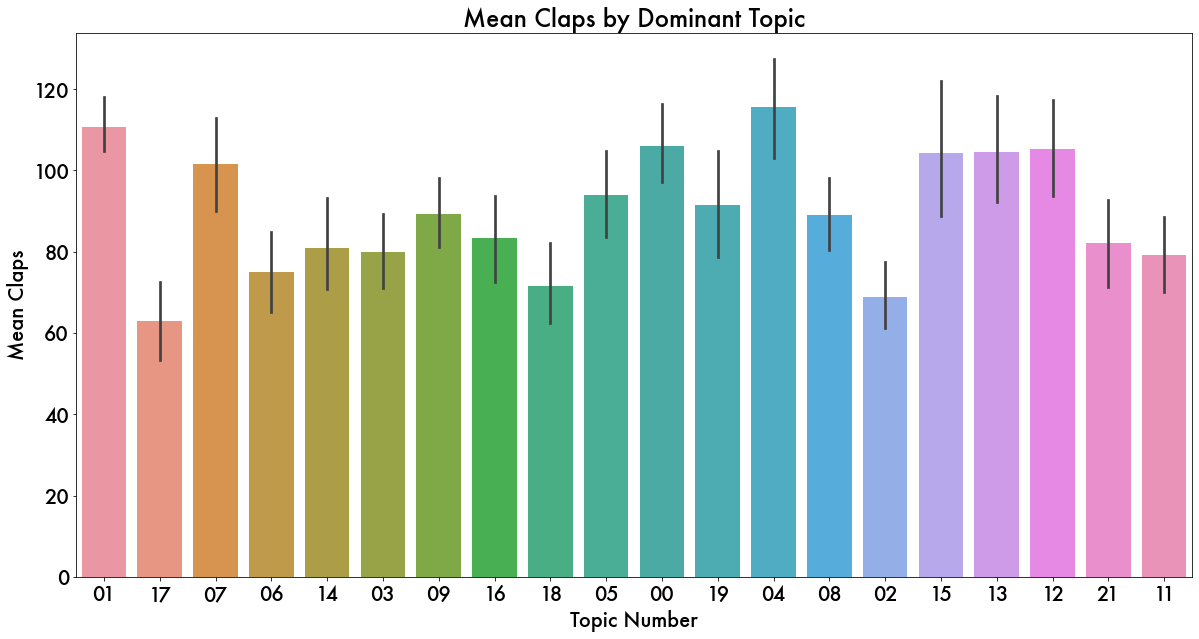

In [241]:
plt.figure(figsize=(20,10));
sns.barplot(data=combined_df, x='Dominant_Topic', y='claps');
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Claps',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_mean_claps_trigram_model22.jpg',  bbox_inches = "tight")

In [242]:
combined_df['Dominant_Topic'].value_counts()

01    1388
00     618
08     583
02     562
09     558
05     544
03     481
04     475
12     466
07     453
21     399
16     397
11     381
18     351
19     299
13     299
06     297
14     266
15     238
17     235
Name: Dominant_Topic, dtype: int64

#### Model Claps by Topic

In [243]:
model_df = pd.get_dummies(combined_df,columns=['Dominant_Topic'], drop_first=True)

In [244]:
model_df.columns

Index(['claps', 'text', 'Topic_Perc_Contrib', 'Keywords', 'Dominant_Topic_01',
       'Dominant_Topic_02', 'Dominant_Topic_03', 'Dominant_Topic_04',
       'Dominant_Topic_05', 'Dominant_Topic_06', 'Dominant_Topic_07',
       'Dominant_Topic_08', 'Dominant_Topic_09', 'Dominant_Topic_11',
       'Dominant_Topic_12', 'Dominant_Topic_13', 'Dominant_Topic_14',
       'Dominant_Topic_15', 'Dominant_Topic_16', 'Dominant_Topic_17',
       'Dominant_Topic_18', 'Dominant_Topic_19', 'Dominant_Topic_21'],
      dtype='object')

In [245]:
import statsmodels.api as sm

In [246]:
model_df.head()

,claps,text,Topic_Perc_Contrib,Keywords,Dominant_Topic_01,Dominant_Topic_02,Dominant_Topic_03,Dominant_Topic_04,Dominant_Topic_05,Dominant_Topic_06,...,Dominant_Topic_11,Dominant_Topic_12,Dominant_Topic_13,Dominant_Topic_14,Dominant_Topic_15,Dominant_Topic_16,Dominant_Topic_17,Dominant_Topic_18,Dominant_Topic_19,Dominant_Topic_21
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,0.5375,"data, science, learn, scientist, project, job, work, machine, skill, learning",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,0.3722,"game, player, team, play, movie, goal, item, top, number, match",0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,0.4125,"layer, input, output, network, neural_network, deep, function, loss, training, learn",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,0.2477,"time, series, data, day, price, month, year, date, change, forecast",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,0.4691,"test, sample, metric, result, error, case, group, number, positive, high",0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [247]:
X = model_df.drop(columns=['text','claps','Topic_Perc_Contrib','Keywords'])
X = sm.add_constant(X, prepend=True)
y = model_df['claps']

In [248]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claps   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     8.142
Date:                Tue, 11 May 2021   Prob (F-statistic):           4.50e-23
Time:                        08:36:20   Log-Likelihood:                -57272.
No. Observations:                9290   AIC:                         1.146e+05
Df Residuals:                    9270   BIC:                         1.147e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               106.1262      4.636     22.892      0.000      97.039     115.214
Dominant_Topic_01     4.6562      5.573      0.835      0.403      -6.268      15.581
Dominant_Topic_02   -37.2846      6.717     -5.550      0.000     -50.452     -24.117
Dominant_Topic_03   -26.0826      7.007     -3.722      0.000     -39.819     -12.346
Dominant_Topic_04     9.4022      7.032      1.337      0.181      -4.383      23.187
Dominant_Topic_05   -12.2475      6.775     -1.808      0.071     -25.529       1.034
Dominant_Topic_06   -31.0757      8.137     -3.819      0.000     -47.026     -15.125
Dominant_Topic_07    -4.5368      7.128     -0.636      0.524     -18.510       9.436
Dominant_Topic_08   -17.0833      6.654     -2.567      0.010     -30.126      -4.040
Dominant_Topic_09   -16.7893      6.730     -2.495      0.013     -29.982      -3.597
Dominant_Topic_11   -27.0422      7.507     -3.602      0.000     -41.757     -12.327
Dominant_Topic_12    -0.9674      7.071     -0.137      0.891     -14.827      12.892
Dominant_Topic_13    -1.4941      8.119     -0.184      0.854     -17.408      14.420
Dominant_Topic_14   -25.2841      8.451     -2.992      0.003     -41.850      -8.718
Dominant_Topic_15    -1.8489      8.792     -0.210      0.833     -19.083      15.385
Dominant_Topic_16   -22.7106      7.413     -3.064      0.002     -37.241      -8.180
Dominant_Topic_17   -43.2624      8.832     -4.898      0.000     -60.576     -25.949
Dominant_Topic_18   -34.6390      7.703     -4.497      0.000     -49.738     -19.540
Dominant_Topic_19   -14.7015      8.119     -1.811      0.070     -30.616       1.213
Dominant_Topic_21   -24.0686      7.401     -3.252      0.001     -38.577      -9.560
==============================================================================
Omnibus:                     4575.950   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25996.245
Skew:                           2.374   Prob(JB):                         0.00
Kurtosis:                       9.680   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Create & Visualize Model with Optimal Number of Topics
There were several repeated words across topics, which may be an indication that there are too many topics. There was a local coherence maximum at 16 topics, so I will model that as well. 

#### LDA Mallet Model: 16 Topics

In [249]:
optimal_model = joblib.load('stored_models/ldamallet_model16_tri.pkl')

In [250]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5011647435397584


In [251]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model16_tri.html') 
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.003809  0.181112       1        1  7.428801
1     -0.279083  0.098065       2        1  5.968003
2     -0.015558 -0.105271       3        1  5.449338
3      0.028775 -0.174408       4        1  8.145428
4      0.006081 -0.177385       5        1  6.838511
5      0.198631  0.135908       6        1  5.346732
6     -0.100511 -0.085467       7        1  5.686954
7      0.047228  0.176785       8        1  7.508789
8     -0.242887  0.121540       9        1  5.509511
9      0.207823  0.083667      10        1  5.800669
10    -0.203668 -0.089182      11        1  6.053870
11     0.038542  0.188853      12        1  7.577895
12     0.045700 -0.048754      13        1  5.432944
13     0.161697 -0.032530      14        1  4.868902
14     0.098000 -0.185133      15        1  7.004128
15     0.005421 -0.087801      16        1  5.379524, topic_info=          Term           Freq          Total Category  logprob  loglift
80        data  126299.000000  126299.000000  Default  30.0000  30.0000
241      model   65602.000000   65602.000000  Default  29.0000  29.0000
932   function   29465.000000   29465.000000  Default  28.0000  28.0000
939      image   19315.000000   19315.000000  Default  27.0000  27.0000
322    science   17343.000000   17343.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
137       find    1570.864843   20201.401898  Topic16  -5.1960   0.3684
1205  generate    1366.959985    7756.957571  Topic16  -5.3350   1.1866
760     result    1482.012364   18214.538017  Topic16  -5.2542   0.4138
27        base    1394.299097   11660.476023  Topic16  -5.3152   0.7988
1010      step    1399.994762   15024.236398  Topic16  -5.3111   0.5494

[1571 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
5034      13  0.864306   abinary
3764       1  1.011741   abraham
6855       4  0.004349  academia
6855      12  0.995925  academia
17958      6  1.001324    accent
...      ...       ...       ...
421       12  0.233859      year
421       14  0.052711      year
1817      15  0.879499     ymean
1343       4  1.075662    youden
2915      13  0.864306        ³⁰

[3519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

Good spread, but lots of topic overlap. 

### Find the Dominant Topic in Each Document

In [252]:
pd.set_option('max_colwidth', 100)

In [253]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_trigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [254]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_trigrams)
df_dominant_topic=pd.DataFrame()
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to pmid numbers
df_dominant_topic.index = df.index


In [255]:
# show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.4919,"data, science, learn, scientist, machine, project, learning, job, work, skill","[ultimate_guide, ace, code, interview, data, scientist, data, science, ultimate_guide, ace, code..."
1,1,5.0,0.3696,"graph, node, game, human, player, ai, team, world, play, edge","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,4.0,0.3645,"image, model, layer, training, deep, input, network, neural_network, output, train","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision_transformer_vit,..."
3,3,6.0,0.2786,"data, column, table, panda, row, dataframe, query, dataset, sql, database","[stock_price, analysis, panda, altair, practical, guide, panda, altairstock, price, analysis, pa..."
4,4,3.0,0.5025,"model, feature, data, dataset, prediction, machine, training, predict, learning, set","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


#### Find the most representative document for each topic

In [256]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to pmid numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [257]:
# Show topics and keywords
doc_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
3472,0.0,0.5760,"time, work, thing, good, start, lot, find, problem, question, make","[avoid, burnout, ambitious, new, data, scientist, avoid, burnout, paramount, avoid, burnout, amb..."
1218,1.0,0.7866,"file, run, code, python, command, package, project, version, create, environment","[publish, python, package, pypi, publish, python, packageshow, publish, python, package, pypi, p..."
1660,2.0,0.6628,"data, plot, cluster, visualization, show, dataset, chart, create, color, map","[ultimate, cheat_sheet, data, visualization, python, seaborn, library, great, resource, ultimate..."
799,3.0,0.7230,"model, feature, data, dataset, prediction, machine, training, predict, learning, set","[ensemble, method, machine, learn, overview, treebased, ensemble, methodsensemble, method, machi..."
7773,4.0,0.7928,"image, model, layer, training, deep, input, network, neural_network, output, train","[paper, read, deep, image, inpainte, paper, read, deep, image, inpainte, image, inpainte, termin..."
5068,5.0,0.7356,"graph, node, game, human, player, ai, team, world, play, edge","[epl_season, analysis, prediction, epl_season, analysis, prediction, home, advantage, even, exis..."
833,6.0,0.7579,"data, column, table, panda, row, dataframe, query, dataset, sql, database","[example, master, sql, comprehensive, practical, tutorial, example, master, sqlsql, programming_..."
8446,7.0,0.7552,"data, team, system, business, process, tool, ai, company, analytic, product","[data, catalog, dead, long, live, data, discovery, opiniondata, catalog, dead, long, live, data,..."
8238,8.0,0.7158,"create, api, app, application, google, service, cloud, build, web, click","[build, job, search, portal, django, user, app, part, second, part, deal, build, job, search, po..."
7643,9.0,0.7623,"customer, high, year, price, analysis, product, group, increase, user, number","[understand, forecasting, customer_lifetime, value, cltv, understanding, forecasting, customer_l..."


#### Explore Relationship Between Dominant Topic and Number of Citations

In [258]:
df.head()

,claps,text
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...


In [259]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.4919,"data, science, learn, scientist, machine, project, learning, job, work, skill","[ultimate_guide, ace, code, interview, data, scientist, data, science, ultimate_guide, ace, code..."
1,1,5.0,0.3696,"graph, node, game, human, player, ai, team, world, play, edge","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,4.0,0.3645,"image, model, layer, training, deep, input, network, neural_network, output, train","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision_transformer_vit,..."
3,3,6.0,0.2786,"data, column, table, panda, row, dataframe, query, dataset, sql, database","[stock_price, analysis, panda, altair, practical, guide, panda, altairstock, price, analysis, pa..."
4,4,3.0,0.5025,"model, feature, data, dataset, prediction, machine, training, predict, learning, set","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


In [260]:
#merge on index
combined_df = pd.DataFrame()
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [261]:
combined_df.columns

Index(['claps', 'text', 'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib',
       'Keywords', 'Text'],
      dtype='object')

In [262]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [263]:
combined_df.head()

,claps,text,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,11.0,0.4919,"data, science, learn, scientist, machine, project, learning, job, work, skill"
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,5.0,0.3696,"graph, node, game, human, player, ai, team, world, play, edge"
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,4.0,0.3645,"image, model, layer, training, deep, input, network, neural_network, output, train"
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,6.0,0.2786,"data, column, table, panda, row, dataframe, query, dataset, sql, database"
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,3.0,0.5025,"model, feature, data, dataset, prediction, machine, training, predict, learning, set"


In [264]:
#the topics are not ordinal, so I will convert them to strings

combined_df['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


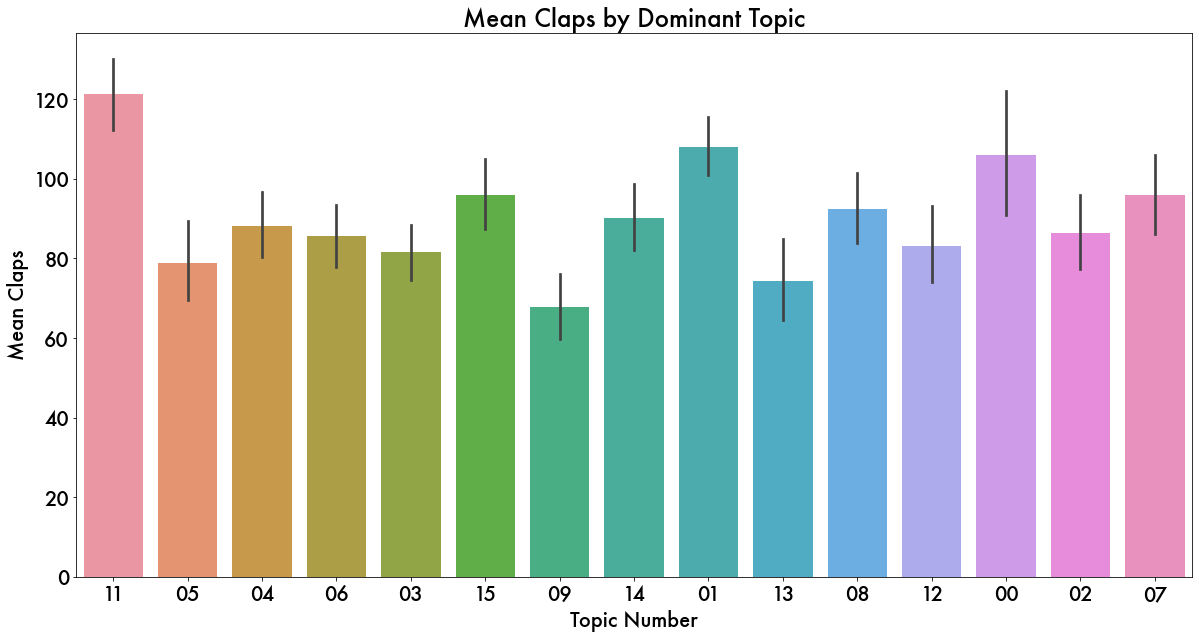

In [265]:
plt.figure(figsize=(20,10));
sns.barplot(data=combined_df, x='Dominant_Topic', y='claps');
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Claps',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_mean_claps_trigram_model16.jpg',  bbox_inches = "tight")

In [266]:
combined_df['Dominant_Topic'].value_counts()

01    1150
11     900
03     813
04     807
07     679
06     636
15     631
08     606
02     593
14     593
09     450
13     411
05     409
12     344
00     268
Name: Dominant_Topic, dtype: int64

#### Model Claps by Topic

In [267]:
model_df = pd.get_dummies(combined_df,columns=['Dominant_Topic'], drop_first=True)

In [268]:
model_df.columns

Index(['claps', 'text', 'Topic_Perc_Contrib', 'Keywords', 'Dominant_Topic_01',
       'Dominant_Topic_02', 'Dominant_Topic_03', 'Dominant_Topic_04',
       'Dominant_Topic_05', 'Dominant_Topic_06', 'Dominant_Topic_07',
       'Dominant_Topic_08', 'Dominant_Topic_09', 'Dominant_Topic_11',
       'Dominant_Topic_12', 'Dominant_Topic_13', 'Dominant_Topic_14',
       'Dominant_Topic_15'],
      dtype='object')

In [269]:
import statsmodels.api as sm

In [270]:
model_df.head()

,claps,text,Topic_Perc_Contrib,Keywords,Dominant_Topic_01,Dominant_Topic_02,Dominant_Topic_03,Dominant_Topic_04,Dominant_Topic_05,Dominant_Topic_06,Dominant_Topic_07,Dominant_Topic_08,Dominant_Topic_09,Dominant_Topic_11,Dominant_Topic_12,Dominant_Topic_13,Dominant_Topic_14,Dominant_Topic_15
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,0.4919,"data, science, learn, scientist, machine, project, learning, job, work, skill",0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,0.3696,"graph, node, game, human, player, ai, team, world, play, edge",0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,0.3645,"image, model, layer, training, deep, input, network, neural_network, output, train",0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,0.2786,"data, column, table, panda, row, dataframe, query, dataset, sql, database",0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,0.5025,"model, feature, data, dataset, prediction, machine, training, predict, learning, set",0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [271]:
X = model_df.drop(columns=['text','claps','Topic_Perc_Contrib','Keywords'])
X = sm.add_constant(X, prepend=True)
y = model_df['claps']

In [272]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claps   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     9.510
Date:                Tue, 11 May 2021   Prob (F-statistic):           2.40e-21
Time:                        08:37:46   Log-Likelihood:                -57283.
No. Observations:                9290   AIC:                         1.146e+05
Df Residuals:                    9275   BIC:                         1.147e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               106.0597      7.046     15.053      0.000      92.248     119.871
Dominant_Topic_01     2.0299      7.824      0.259      0.795     -13.307      17.367
Dominant_Topic_02   -19.5960      8.490     -2.308      0.021     -36.239      -2.953
Dominant_Topic_03   -24.4976      8.125     -3.015      0.003     -40.424      -8.571
Dominant_Topic_04   -17.9407      8.132     -2.206      0.027     -33.882      -2.000
Dominant_Topic_05   -27.0719      9.065     -2.986      0.003     -44.842      -9.302
Dominant_Topic_06   -20.4056      8.400     -2.429      0.015     -36.872      -3.939
Dominant_Topic_07    -9.9861      8.321     -1.200      0.230     -26.297       6.325
Dominant_Topic_08   -13.7231      8.462     -1.622      0.105     -30.310       2.864
Dominant_Topic_09   -38.2553      8.900     -4.298      0.000     -55.702     -20.809
Dominant_Topic_11    15.2314      8.027      1.898      0.058      -0.503      30.966
Dominant_Topic_12   -22.8504      9.398     -2.431      0.015     -41.273      -4.428
Dominant_Topic_13   -31.6801      9.056     -3.498      0.000     -49.433     -13.928
Dominant_Topic_14   -15.8590      8.490     -1.868      0.062     -32.502       0.784
Dominant_Topic_15   -10.0074      8.410     -1.190      0.234     -26.493       6.478
==============================================================================
Omnibus:                     4588.156   Durbin-Watson:                   1.521
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26171.527
Skew:                           2.380   Prob(JB):                         0.00
Kurtosis:                       9.705   Cond. No.                         24.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""